# __Credit Card Fraud Detection - What Features are Most Critical?__

<img src="https://www.elenavandesande.com/wp-content/uploads/2016/10/shutterstock_transactionfraud.jpeg" alt='Credit Card Fraud' width="400"><br>

With global fraud at an all time high, and as someone who has been the victim of fraudulent transactions more than once (unfortunately), this project is a study into fraudulent card transactions using credit card transaction data. It involves data validation, feature engineering, data analysis, and development and evaluation of binary classification models.

The study aims to identify which characteristics of a credit card transaction are most important to determine whether it is fraudulent or legitimate. __Several new features will be engineered__ and derived from the existing data to capture important *customer and transaction details* as well as *customer purchase history and spending behaviour*. These new features will be evaluated later in a binary classification model to gauge how they may affect a model's performance.

This dataset consists of credit card transactions in the western United States. It was sourced from [Credit Card Transactions Fraud Detection Dataset](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv) and was partly adapted by the data science learning platform DataCamp.

__This study involves the following sections__:

1. Data Validation - Initial data overview and preparation
2. Feature Engineering - Create several new features to assist with analysis and predictions
3. Exploratory Data Analysis - Visualizing distributions, analyzing feature relationships
3. Machine Learning - Developing and evaluating classification machine learning models for fraud detection

## 💾 1. __Data Validation__

Let's begin by importing packages, getting an overview of the dataset, and preparing the data for later operations.

In [1]:
# Import packages for numeric operations and working with structured data
import numpy as np
import pandas as pd

# Import visualization packages
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Import datetime packages
from datetime import date

# Import machine learning with sci-kit learn packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Import packages to work with geographical data
from geopy import distance

In [2]:
# Read in CSV file as a DataFrame and inspect first 5 rows
df = pd.read_csv('credit_card_fraud.csv')
df.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0
1,2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0
2,2019-01-01 00:07:27,Kiehn Inc,grocery_pos,96.29,Grenada,CA,41.6125,-122.5258,589,Systems analyst,1945-12-21,413636e759663f264aae1819a4d4f231,41.657520,-122.230347,0
3,2019-01-01 00:09:03,Beier-Hyatt,shopping_pos,7.77,High Rolls Mountain Park,NM,32.9396,-105.8189,899,Naval architect,1967-08-30,8a6293af5ed278dea14448ded2685fea,32.863258,-106.520205,0
4,2019-01-01 00:21:32,Bruen-Yost,misc_pos,6.85,Freedom,WY,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,f3c43d336e92a44fc2fb67058d5949e3,43.753735,-111.454923,0


In [3]:
# Obtain DataFrame general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  339607 non-null  object 
 1   merchant               339607 non-null  object 
 2   category               339607 non-null  object 
 3   amt                    339607 non-null  float64
 4   city                   339607 non-null  object 
 5   state                  339607 non-null  object 
 6   lat                    339607 non-null  float64
 7   long                   339607 non-null  float64
 8   city_pop               339607 non-null  int64  
 9   job                    339607 non-null  object 
 10  dob                    339607 non-null  object 
 11  trans_num              339607 non-null  object 
 12  merch_lat              339607 non-null  float64
 13  merch_long             339607 non-null  float64
 14  is_fraud               339607 non-nu

The above inspections reveal the dataset columns are:

- <code>transdatetrans_time</code> : Transaction DateTime
- <code>merchant</code> : Merchant Name
- <code>amt</code> : Amount of Transaction
- <code>city</code> : City of Credit Card Holder
- <code>state</code> : State of Credit Card Holder
- <code>lat</code> : Latitude Location of Purchase
- <code>long</code> : Longitude Location of Purchase
- <code>city_pop</code> : Credit Card Holder's City Population
- <code>job</code> : Job of Credit Card Holder
- <code>dob</code> : Date of Birth of Credit Card Holder
- <code>trans_num</code> : Transaction Number
- <code>merch_lat</code> : Latitude Location of Merchant
- <code>merch_long</code> : Longitude Location of Merchant
- <code>is_fraud</code> : Whether Transaction is Fraud (1) or Not (0)

In [4]:
# Check dataset for duplicates
number_dup = df.duplicated().sum()
print(f'The total number of duplicates is {str(number_dup)}')

The total number of duplicates is 0


In [5]:
# Create empty lists to store fraudulent and legitimate transaction counts and percentages of total
target_count_list = []
target_perc_list = []

# Create a variable storing the number of fraudulent observations
fraud_count = len(df[df['is_fraud']==1])
target_count_list.append(fraud_count)

# Create a variable storing the number of legitimate observations
legit_count = len(df[df['is_fraud']==0])
target_count_list.append(legit_count)

# Get percentage of counts from total
for i in target_count_list:
    perc_of_whole = f"{i/len(df):.2%}"
    target_perc_list.append(perc_of_whole)

# Combine the count and percent columns into DataFrame
count_percentage = pd.concat(
    [pd.Series(target_count_list), pd.Series(target_perc_list)], axis=1).rename(columns = {0: 'Count', 1: 'Percentage of total'}).rename(index = {0: 'Fraudulent Transaction', 1: 'Legitimate Transaction'})
count_percentage.head()

,Count,Percentage of total
Fraudulent Transaction,1782,0.52%
Legitimate Transaction,337825,99.48%


In [6]:
# Inspect the categorical variables
df.select_dtypes(['object','bool']).nunique().head()

trans_date_trans_time    338504
merchant                    693
category                     14
city                        176
state                        13
dtype: int64

In [7]:
# Transform date columns to Date Time objects for later operation
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Output the final values
print('The column "trans_date_trans_time" is now of type {}'.format(str(df['trans_date_trans_time'].dtype)))
print('The column "dob" is now of type {}'.format(str(df['dob'].dtype)))

The column "trans_date_trans_time" is now of type datetime64[ns]
The column "dob" is now of type datetime64[ns]


In [8]:
# Create a Pandas Series and get the first date available in the transaction date/time column
min = df['trans_date_trans_time'].dt.date.min().strftime("%d-%m-%Y")
                              
# Create a Pandas Series and get the last date available in the transaction date/time column
max = df['trans_date_trans_time'].dt.date.max().strftime("%d-%m-%Y")

print('The transaction dates contained in the dataset range from the {} to the {}'.format(min, max))

The transaction dates contained in the dataset range from the 01-01-2019 to the 31-12-2020


### __Data Overview Findings__

- The dataset consists of 339,607  observations, each relating to a unique credit card transaction made, and each column represents attributes of the transactions with a mix of numerical and categorical variables.
- No missing or duplicates values were found.
- The Dataset includes transactions made between 01/01/2019 and 31/12/2020.
- There exists a class imbalance problem for fraud classification, where only 0.52% (1782 observations) of all observations are fraudulent. This should be noted for the final machine learning section of this project.

## 🔧 2. __Feature Engineering__

Now that we have a better understanding of the dataset, we will begin by using existing features to engineer new meaningful features. The new engineered features entail __Credit Card Holder Details__, __Transaction Details__ and __Credit Card Holder Purchase Behaviour__.

### __Credit Card Holder Details__

Firstly, we will engineer features related to credit card holder information:

- *card_id: Create unique identifier for rows which represent transactions made on the same card*

As there is currently no column in the DataFrame that represents transactions which belong to the same credit card, we will use other columns of personal details such as <code>dob</code>, <code>job</code> and <code>city</code> to derive a <code>card_id</code> unique identifier for the observations which belong to the same card. This will allow us to analyze purchase behaviour later on.<br> 


- *age: Determine card holder age*

By obtaining the difference between a person's date of birth <code>dob</code> and today's date, we can obtain a person's age. It is possible that people of certain age demographics are more susceptible to fraud.

In [9]:
# Create new column representing each unique credit card in the dataset inferred by a unique combination of other personal features
df['card_id'] = df.groupby(['job', 'dob', 'city']).ngroup() + 1

# Subset DataFrame to include only 'card_id' 42
card_id_42_df = df[df['card_id']==42]

# Check that a unique 'card_id' corresponds to unique combination of personal features
card_id_42_df.head(3)

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,card_id
10,2019-01-01 00:40:50,Cummerata-Jones,gas_transport,70.53,Athena,OR,45.8289,-118.4971,1302,Dealer,1976-10-18,7b91bd200c11c5cd24b43694e12b5bbc,46.043252,-117.962133,0,42
173,2019-01-01 10:47:11,"Adams, Kovacek and Kuhlman",grocery_net,47.54,Athena,OR,45.8289,-118.4971,1302,Dealer,1976-10-18,8b84871f95118c170b525195e68d8c03,45.542176,-118.562415,0,42
217,2019-01-01 13:11:57,Padberg-Rogahn,entertainment,81.67,Athena,OR,45.8289,-118.4971,1302,Dealer,1976-10-18,3e7217f3499fa2b8616b800aa8edabce,45.184297,-118.779534,0,42


In [10]:
# Define a function to extract age from date of birth
def age(date_of_birth):
    today = date.today()
    return (date.today().year - date_of_birth.year)

# Create a new column with person's age
df['age'] = df['dob'].apply(age)

df.head(3)

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,card_id,age
0,2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,159,44
1,2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,114,60
2,2019-01-01 00:07:27,Kiehn Inc,grocery_pos,96.29,Grenada,CA,41.6125,-122.5258,589,Systems analyst,1945-12-21,413636e759663f264aae1819a4d4f231,41.657520,-122.230347,0,166,77


### __Transaction Details__

Secondly, we will engineer features related to transaction details:

- *distance_from_merchant(km): Determine distance between card holder's location, and the merchant's location where a transaction has taken place*

Given the geographical location of a credit card holder, and location of the merchant, we can derive the distance between the two. There is a chance that transactions made at locations far from the card holder are suspicious.

- *day*, *month* and *year* (3 columns respectively): Extract the day, month and year of each transaction date*

The transaction date column will be used to extract the components of the date, which could later reveal For example, whether there is a time of the year where fraud is more common.

- *Check whether transaction is a whole number: *is_whole_number**

If a transaction has a whole number as opposed to numbers with decimals, this could also be an indicator of a suspicious transaction.

In [11]:
# Specify the customer and merchant coordinate columns
customer_lat, customer_long = "lat", "long"
merchant_lat, merchant_long = "merch_lat", "merch_long"

# Create function to calculate the distance between two sets of coordinates
calculate_distance = lambda x: distance.geodesic(
    (x[customer_lat], x[customer_long]), (x[merchant_lat], x[merchant_long])).km

# Create a new column for the distance
df["distance_from_merchant(km)"] = df.apply(calculate_distance, axis=1)

In [12]:
# Create a column showing whether the transaction amount is a whole number
df["is_whole_number"] = df['amt'] == df['amt'].astype(int)

In [13]:
# Extract the hour, day, and month from the transaction column which is a datetime type
df["hour"] = df['trans_date_trans_time'].dt.hour
df["day"] = df['trans_date_trans_time'].dt.day
df["month"] = df['trans_date_trans_time'].dt.month

### __Credit Card Holder Purchase Behaviour__

Thirdly, we will engineer features related to a person' purchase behaviour:

- *avg_amount: Average transaction amount for all transactions of the same card*

- *avg_amt_30_day: Average monthly transaction amount of the same card over the past 30 days from the observation's date*

- *avg_amt_cat_30_day: Average transaction amount of the same card per category for the past 30 days from the observation's date*

The idea with each of these features is to uncover purchasing habits and behaviours. Any transactions which deviate and show discrepancies from the personal purchase behaviour captured in these new features could be an indicator that someone else is actually making the purchase, and could signify a fraudulent transaction.

In [14]:
# Set the DataFrame transaction date & time columns to be index
df = df.set_index('trans_date_trans_time').sort_index()

In [15]:
# Calculate the average transaction amount for the credit card across all purchases made on that card
df['avg_amount_all'] = df.groupby('card_id')['amt'].transform(np.mean)

In [16]:
# Create function that returns 30 day rolling average of a given group
def get_monthly_rolling_mean(dataframe, col_1, col_2):
    monthly_rolling_mean = (
    dataframe.groupby(col_1)[col_2]
    .rolling('30D')
    .mean().reset_index()
    )
    return monthly_rolling_mean

# Create function that renames a column with new name
def rename_new_column(dataframe, col_name, new_name):
    dataframe = dataframe.rename(columns={col_name: new_name})
    return dataframe

# Create function that merges DataFrame on specified column(s), sets index and sorts index
def merge_new_column_with_df(dataframe1, dataframe2, cols, pick_index):
    dataframe1 = (dataframe1.merge(dataframe2, on=cols).set_index(pick_index).sort_index())
    return dataframe1

In [17]:
# Calculate the average amount spent per credit card for the past 30 days
monthly_rolling_mean = get_monthly_rolling_mean(df, 'card_id', 'amt')

# Rename newly created column 
monthly_rolling_mean = rename_new_column(monthly_rolling_mean, 'amt', 'avg_amt_30_day')

# Merge with original DataFrame
df = merge_new_column_with_df(df, monthly_rolling_mean, ['card_id', 'trans_date_trans_time'], 'trans_date_trans_time')

In [18]:
# Calculate the average amount spent per credit card for the past 30 days on a product category
cat_monthly_rolling_mean = get_monthly_rolling_mean(df, ['card_id', 'category'], 'amt').drop(columns='category')

# Rename newly created column
cat_monthly_rolling_mean = rename_new_column(cat_monthly_rolling_mean, 'amt', 'avg_amt_cat_30_day')

# Merge with original DataFrame
df = merge_new_column_with_df(df, cat_monthly_rolling_mean, ['card_id', 'trans_date_trans_time'], 'trans_date_trans_time')

In [19]:
df.head()

,merchant,category,amt,city,state,lat,long,city_pop,job,dob,...,card_id,age,distance_from_merchant(km),is_whole_number,hour,day,month,avg_amount_all,avg_amt_30_day,avg_amt_cat_30_day
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,...,159,44,30.216618,False,0,1,1,56.078113,107.23,107.23
2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,...,114,60,108.102912,False,0,1,1,69.924272,220.11,220.11
2019-01-01 00:07:27,Kiehn Inc,grocery_pos,96.29,Grenada,CA,41.6125,-122.5258,589,Systems analyst,1945-12-21,...,166,77,25.120545,False,0,1,1,68.920655,96.29,96.29
2019-01-01 00:09:03,Beier-Hyatt,shopping_pos,7.77,High Rolls Mountain Park,NM,32.9396,-105.8189,899,Naval architect,1967-08-30,...,115,55,66.155859,False,0,1,1,64.076639,7.77,7.77
2019-01-01 00:21:32,Bruen-Yost,misc_pos,6.85,Freedom,WY,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,...,49,55,88.802805,False,0,1,1,69.422480,6.85,6.85


Now __there are an additional 10 meaningful features available in the DataFrame__ that can be used for analysis and machine learning.

In [20]:
df.describe()

,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,card_id,age,distance_from_merchant(km),hour,day,month,avg_amount_all,avg_amt_30_day,avg_amt_cat_30_day
count,339677.000000,339677.000000,339677.000000,3.396770e+05,339677.000000,339677.000000,339677.000000,339677.000000,339677.000000,339677.000000,339677.000000,339677.000000,339677.000000,339677.000000,339677.000000,339677.000000
mean,70.572328,39.719448,-110.622352,1.071227e+05,39.719271,-110.622113,0.005246,95.066575,50.267124,75.585681,12.813570,15.849401,7.158194,70.575695,70.569663,70.561418
std,161.659592,5.095217,12.651394,2.930029e+05,5.131063,12.664077,0.072240,54.227907,16.985504,29.032214,6.812477,8.872913,3.424074,19.091838,28.215657,86.012476
min,1.000000,20.027100,-165.672300,4.600000e+01,19.027422,-166.671575,0.000000,1.000000,21.000000,0.205421,0.000000,1.000000,1.000000,45.906379,1.280000,1.000000
25%,9.600000,36.715400,-120.093600,4.710000e+02,36.817288,-119.823247,0.000000,48.000000,37.000000,54.768183,7.000000,8.000000,4.000000,59.842432,53.157500,38.337143
50%,46.460000,39.617100,-111.098500,1.645000e+03,39.586380,-111.037249,0.000000,95.000000,48.000000,77.651531,14.000000,16.000000,7.000000,64.333357,63.592903,58.245000
75%,83.340000,41.710000,-100.621500,3.543900e+04,42.193374,-100.350647,0.000000,142.000000,61.000000,97.914555,19.000000,23.000000,10.000000,87.157529,84.421400,79.555000
max,28948.900000,66.693300,-89.628700,2.383912e+06,67.510267,-88.629203,1.000000,187.000000,95.000000,151.868200,23.000000,31.000000,12.000000,859.882000,1433.540000,8421.185000


## 🔎 3. __Exploratory Data Analysis__

Let's now __visualize some of the data's feature distributions and value counts__, specifically the amounts <code>amt</code> of fraudulent and non-fraudulents transactions, and the <code>age</code>, <code>job</code> and <code>category</code> values present in fraudulents transactions. Values that are identified to occur more frequently for features in fraudulent data could be indicators that a given transaction is fraudulent.

The machine learning model development in the final section can help reinforce or contradict the importance of certain features explored here when it comes to determining the legitimacy of a transaction.

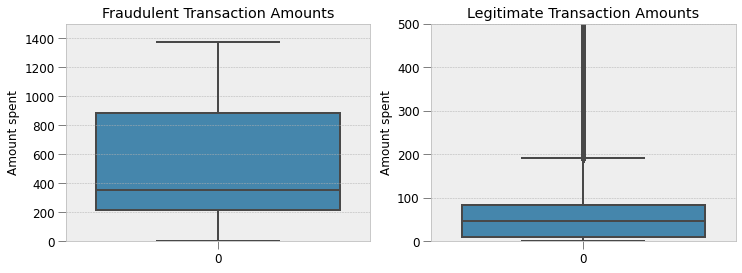

In [21]:
# Set plotting style
plt.style.use('bmh')

# Create Pandas Series of 'amt' for fraudulent transactions
amounts_fraud = df[(df['is_fraud']==1)]['amt']

# Create Pandas Series of 'amt' for legitimate transactions
amounts_legit = df[df['is_fraud']==0]['amt']

# Create figure and axis object
fig, ax = plt.subplots(1, 2)

# Set figure size
fig.set_size_inches(12, 4)

# Plot boxplot of amounts_fraud
sns.boxplot(amounts_fraud, ax=ax[0])

# Set boxplot labels, range limits and tick formatting
ax[0].set_title('Fraudulent Transaction Amounts')
ax[0].set_ylabel('Amount spent')
ax[0].set_ylim(0, 1500)
ax[0].tick_params(left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)

# Plot boxplot of amounts_legit
sns.boxplot(amounts_legit, ax=ax[1])

# Set boxplot labels, range limits and tick formatting
ax[1].set_title('Legitimate Transaction Amounts')
ax[1].set_ylabel('Amount spent')
ax[1].set_ylim(0, 500)
ax[1].tick_params(left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)

plt.show()

### __Insights on "Amount" Feature Distribution__

- Given the amount <code>amt</code> distributions of fraudulent transactions is higher than that of legitimate transaction, higher transaction amounts can be an indicator of fraud. This makes sense as a perpetrator is trying to maximize the amount of monetary gain from fraud on a single transaction.

- The interquartile ranges captured further solidify this, showing that 50% of fraud transaction amounts are somewhere between \$200 and \$900, while in the non-fraudulent case 50% of transaction amounts are between around \$15 and \$75. Additionally, the IQR for fraud amounts is higher than the entire percentile range of non-fraud amounts.

- Further, the 25th percentile value of fraud amounts is more than double the 75th percentile value of non-fraud amounts. This means that while 25% of fraudulent transactions amounts are of around \$200 of lower, 75% of non-fraudulent amounts are around \$80 or lower.

- There are lots of outliers shown in the legitimate transactions boxplot which represent transactions of $200 and over. 

In [22]:
# Create DataFrame consisting only of fraudulent transactions
fraud_df = df[(df['is_fraud']==1)]

# Create new categorical variable age group for each observations' age
fraud_df['age_group'] = pd.cut(fraud_df['age'],
                      bins=np.arange(0, 100, 10),
                      labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])

# Get indexes for unique 'age_group' values in the fraudulent transactions DataFrame
ageg_indexes = fraud_df['age_group'].value_counts(sort=False).index.tolist()

# Get values for unique 'age_group' values in the fraudulent transactions DataFrame
ageg_values = fraud_df['age_group'].value_counts(sort=False).tolist()

# Check categories and corresponding values
print(ageg_indexes)
print(ageg_values)

['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
[0, 0, 204, 311, 312, 345, 293, 109, 164]


C:\Users\ricar\AppData\Local\Temp/ipykernel_23756/2342488932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['age_group'] = pd.cut(fraud_df['age'],


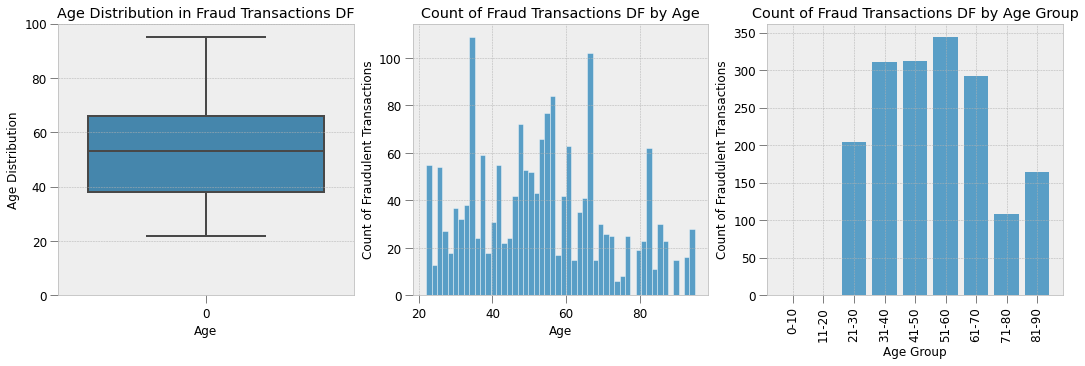

In [23]:
# Create figure and axis object
fig, ax = plt.subplots(1, 3)

# Set figure size
fig.set_size_inches(18, 5)

# Create boxplot of 'age'
sns.boxplot(fraud_df['age'], ax=ax[0])

# Set labels and title
ax[0].set_title('Age Distribution in Fraud Transactions DF')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Age Distribution')

# Set ranges
ax[0].set_ylim(0, 100)

# Format plot ticks
ax[0].tick_params(left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)

# Create histogram of 'age' in fraud_df
ax[1].hist(fraud_df['age'], alpha=0.8, edgecolor ='white', bins=50)

# Set labels and title
ax[1].set_title('Count of Fraud Transactions DF by Age')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Count of Fraudulent Transactions')

# Format plot ticks
ax[1].tick_params(left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)

# Create bar plot of category counts in fraud_df
ax[2].bar(ageg_indexes, ageg_values, alpha=0.8)

# Set labels and title
ax[2].set_title('Count of Fraud Transactions DF by Age Group')
ax[2].set_xlabel('Age Group')
ax[2].set_ylabel('Count of Fraudulent Transactions')

# Format plot ticks
ax[2].set_xticks(ageg_indexes, rotation = 90)
ax[2].set_xticklabels(ageg_indexes, rotation = 90)
ax[2].tick_params(left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)

# Format plot ticks
ax[2].tick_params(left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)

plt.show()

In [24]:
# Get indexes for the 20 most frequent 'job' values in the fraudulent transactions DataFrame
job_indexes = fraud_df['job'].value_counts().sort_values().nlargest(20).index.tolist()

# Get values for the 20 most frequent 'job' values in fraudulent transactions DataFrame
job_values = fraud_df['job'].value_counts().sort_values().nlargest(20).tolist()

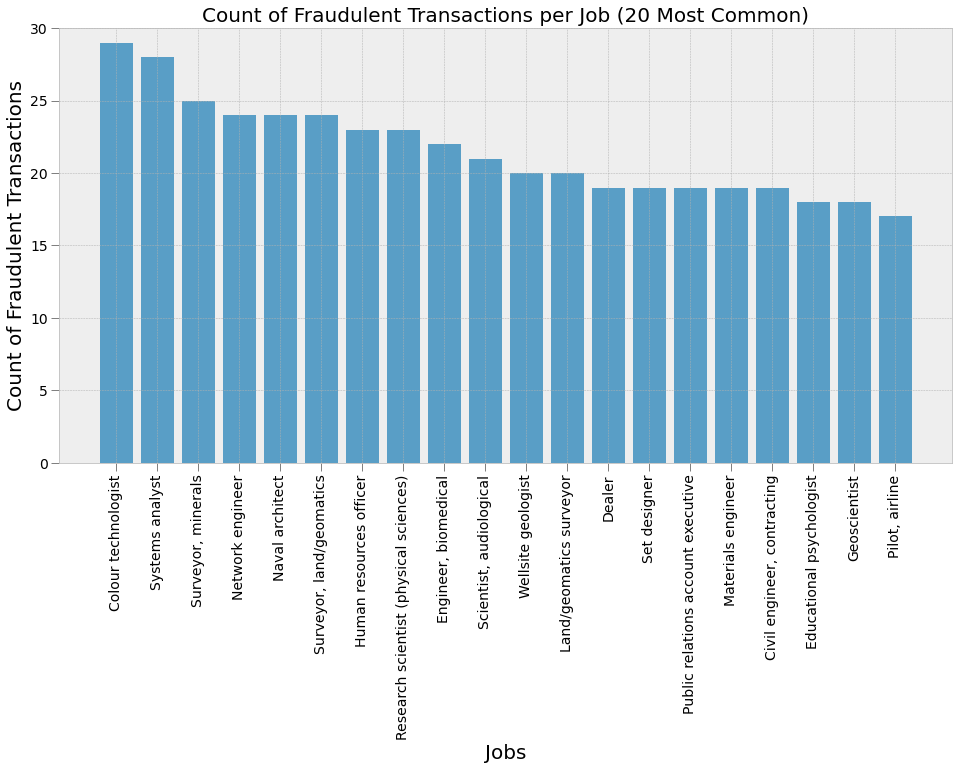

In [42]:
# Create figure and axis object
fig, ax = plt.subplots()

# Set figure size
fig.set_size_inches(16,8)

# Create bar plot of job counts in fraud_df
ax.bar(job_indexes, job_values, alpha=0.8)

# Set title and labels
ax.set_title('Count of Fraudulent Transactions per Job (20 Most Common)', fontsize=20)
ax.set_xlabel('Jobs', fontsize=20)
ax.set_ylabel('Count of Fraudulent Transactions', fontsize=20)

# Format plot ticks
ax.set_xticks(job_indexes, rotation = 90)
ax.set_xticklabels(job_indexes, rotation = 90)
ax.tick_params(left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=14)

# Set range limit
ax.set_ylim(0, 30)

plt.show()

In [26]:
# Get indexes for unique 'category' values in the fraudulent transactions DataFrame
cat_indexes = fraud_df['category'].value_counts().sort_values(ascending = False).index.tolist()

# Get values for unique 'category' values in the fraudulent transactions DataFrame
cat_values = fraud_df['category'].value_counts().sort_values(ascending = False).tolist()

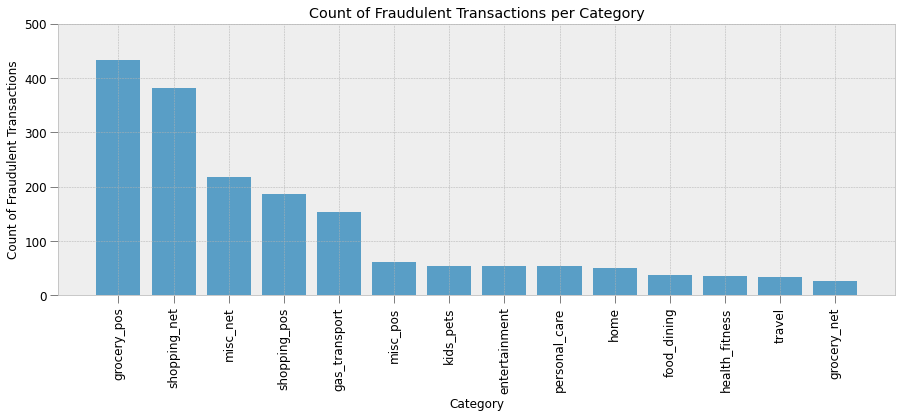

In [27]:
# Create figure and axis object
fig, ax = plt.subplots()

# Set figure size
fig.set_size_inches(15,5)

# Create bar plot of category counts in fraud_df
ax.bar(cat_indexes, cat_values, alpha=0.8)

# Set title and labels
ax.set_title('Count of Fraudulent Transactions per Category')
ax.set_xlabel('Category')
ax.set_ylabel('Count of Fraudulent Transactions')

# Format plot ticks
ax.set_xticks(cat_indexes, rotation = 90)
ax.set_xticklabels(cat_indexes, rotation = 90)
ax.tick_params(left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)

# Set ranges
ax.set_ylim(0, 500)

plt.show()

### __Insights on "Age", "Job" and "Category" Features for Fraudulent Transactions__

- It appears __all age groups are at risk of becoming fraud victims__, and no real "one age group" is most susceptible or likely to be targetted. The interquartile range lies approximately between 38 and 65 which represents 50% of all observations, with a median of about 52.

- Among the top 20 job occupations that have the highest count of fraudulent transactions in the dataset, several of these professions are highly technical. However, this does not indicate that these jobs are most susceptible to fraud, as a single card could have been compromised and several fraudulent transaction made on that same card (which belongs to 1 person working 1 job).

- In terms of spending categories in fraudulent transactions, __grocery point of sale__, and __Internet shopping__ are the most frequently occurring categories, with around 400 fraudulent transaction counts each. These are then followed by __miscellaneous Internet shopping__, __point of sale shopping__ and __gas_transport__, with around 220, 180 and 150 counts respectively.

## 🎯 4. __Machine Learning__

In this final section, a __machine learning binary classification model for fraud detection will be developed and evaluated__ using suitable metrics. It will also reveal whether any of the engineered features are important for the model's learning.

It is worth noting that __there is a significant class imbalance problem__, with the fraud transactions making up only approximately 0.5% of all transactions in the dataset, the rest of which are not fraud (i.e. legitimate). This means that accuracy is not the best metric to evaluate performance, because if the model classifies all observations as "not fraud" then it will achieve an accuracy of around 99.5%, but will fail at its original purpose of identifying the very few observations which are in fact fraud. For this reason, we will refer to other performance metrics for a classification problem:

- *Precision*: Out of the model's classifications which are positive (predicted as fraud in our case), how many are actually positive in the real dataset?

- *Recall*: Out ot the dataset's observations which are actually positive for fraud, how many did the model successfully detect as such?

- *AUC Score*: The greater the area under the curve of an ROC (receiver operating characteristic), the better the model is at distinguishing and correctly predicting the class of a data point.

### __Developing and Evaluating a Binary Classification Machine Learning Model__

First let's prepare the data for the purposes of machine learning by ensuring all categorical features are expressed numerically, removing redundant features, and setting up explanatory and target variable sets. Then, let's scale the data to ensure they work across a common scale without distorting the differences in the range of values, and train and test different models on this data to compare how different learning methods perform.

In [28]:
# sampled_data = df.groupby('is_fraud', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))

# sampled_data.reset_index(inplace = True)

# sampled_data['is_fraud'].value_counts()

In [29]:
# Reset the DataFrame Index
df.reset_index(inplace = True)

# Create Series of target variable is_fraud
target = df['is_fraud']

# Drop columns for training data preparation
prep_df = df.drop(['is_fraud', 'trans_date_trans_time', 'lat', 'long', 'merch_lat', 'merch_long', 'card_id', 'trans_num', 'dob'], axis=1)

# Convert categorical variables from explanatory variables into indicator/dummy variables
train_set = pd.get_dummies(prep_df, drop_first=True)

In [30]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_set, target, test_size=0.3, random_state=10)

# Instantiate models with default parameters to be evaluated
models = {
    'LogisticRegression': LogisticRegression(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'RandomForestClassification': RandomForestClassifier(),
    }

# Create empty lists to store performance metrics from each model
accuracy_results = []
precision_results = []
recall_results = []
model_names = []

# Create empty dictionary to store True Positive Rate, False Positive Rate and Threshold of each model
roc_probs = {}

# Create empty dictionary to store the "area under curve" of each model's ROC
roc_auc_scores = {}

# Fit, train and test each model on the data sets
for name, model in models.items():

    # Set up pipeline steps
    steps = [('scaler', StandardScaler()),
            (name, model)]
    
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)

    # Fit and train model with the training data, predict on test set, calculate performance scores
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    y_pred = pipeline.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Get roc_auc metrics for True Positive Rate and False Positive Rate
    binary_prediction = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, binary_prediction)
    roc_probs[name] = fpr, tpr, thresholds
    
    # Store "area under curve" score of each "receiver operating characteristic" curve
    roc_auc_scores[name] = roc_auc_score(y_test, binary_prediction)
    
    # Append performance metric in relevant list
    accuracy_results.append(score)
    recall_results.append(recall)
    precision_results.append(precision)
    model_names.append(name)

# Create DataFrame from above lists
ml_results = pd.DataFrame([model_names, accuracy_results, precision_results, recall_results]).transpose()

# Rename results DataFrame columns for clarity
ml_results = ml_results.rename(columns={0:'Model Name', 1:'Accuracy', 2:'Precision', 3:'Recall'}).sort_values('Recall', ascending=False)

# Check results
ml_results.head()

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model Name,Accuracy,Precision,Recall
1,GradientBoostingClassifier,0.998057,0.878282,0.714563
2,RandomForestClassification,0.997468,0.988593,0.504854
0,LogisticRegression,0.995535,0.66129,0.238835


In [38]:
# Print the AUC of each model evaluated
for key, val in roc_auc_scores.items():
    print(f'The Area Under Curve (AUC) for {key} is {val:.4} \n')   

The Area Under Curve (AUC) for LogisticRegression is 0.832 

The Area Under Curve (AUC) for GradientBoostingClassifier is 0.9832 

The Area Under Curve (AUC) for RandomForestClassification is 0.9753 



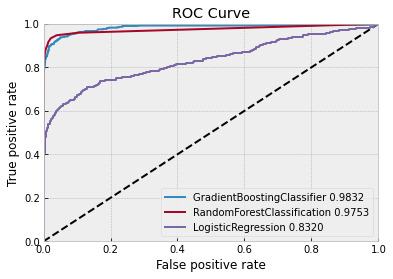

In [32]:
# Plot from 0 to 1 in both axis
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title for the graph
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')

# Set plot x-axis and y-axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Plot LogisticRegression model's FPR and TPR
plt.plot(roc_probs['GradientBoostingClassifier'][0], roc_probs['GradientBoostingClassifier'][1], label='GradientBoostingClassifier %.4f'% roc_auc_scores['GradientBoostingClassifier'])

# Plot RandomForestClassification model's FPR and TPR 
plt.plot(roc_probs['RandomForestClassification'][0], roc_probs['RandomForestClassification'][1], label='RandomForestClassification %.4f'% roc_auc_scores['RandomForestClassification'])

# Plot KNeighborsClassifier model's FPR and TPR
plt.plot(roc_probs['LogisticRegression'][0], roc_probs['LogisticRegression'][1], label='LogisticRegression %.4f'% roc_auc_scores['LogisticRegression'])

# Create legend
plt.legend()

plt.show()

### __Insights on Machine Learning Model Testing__

- All models have over 99% accuracy but have varying precision, recall and AUC scores.
- Out of the 2 best models tested, the *GradientBoostingClassifier* has a Precision of 87.8% and Recall of 71.5%, while *RandomForestClassifier* has a Precision of 98.8% and Recall of 50.5%. While the *GradientBoostingClassifier* has successfully detected 71.5% of the positive (fraud) observations in the testing dataset, the *RandomForestClassifier* has only detected 50.5%.
- On the other hand, the *GradientBoostingClassifier* positive predictions were correct 87.8% of the time, while the *RandomForestClassifier* positive predictions were only correct 71.5% of the time.
- Despite having a lower AUC score and Precision, the *RandomForestClassifier* is better at detecting fraud as demonstrated by its Recall score, so it will be used moving forward. Due to the significant class imbalance, it is better to have a few incorrectly labelled non-fraudulent transactions so long as most or all fraudulent transactions were successfully detected by the algorithm, and then manually looking through the model's positively classified observations to rule out incorrectly labelled legitimate transactions.

### __Investigating the Better Learning Method__

Let's look further into the best model's feature importances, performance metrics and confusion matrix.

In [33]:
# Set up final pipeline with best estimator from previous tests
steps_final = ([('scaler', StandardScaler()), ('GradientBoostingClassifier', GradientBoostingClassifier())])

# Instantiate pipeline object with steps
pipeline_final = Pipeline(steps_final)

# Fit the model to the training data
pipeline_final.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline_final.predict(X_test)

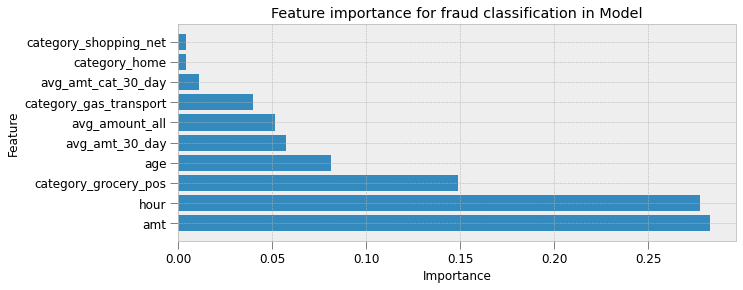

In [34]:
# Create Pandas Series with the 10 most important features in the model
feature_importance_labelled = pd.Series(pipeline_final['GradientBoostingClassifier'].feature_importances_, index=train_set.columns).nlargest(10)

# Set figure size
plt.figure(figsize=(10,4))

# Plot horizontal barplot of feature importance
plt.barh(y = feature_importance_labelled.index, width = feature_importance_labelled)

# Format plot
plt.tick_params(left=True, length=8, width=1, which='major', direction='out', color='grey', labelsize=12)

# Set labels
plt.title('Feature importance for fraud classification in Model')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()

In [35]:
# Get final binary classification model performance metrics
final_score = accuracy_score(y_test, y_pred)
final_precision = precision_score(y_test, y_pred)
final_recall = recall_score(y_test, y_pred)

# Print final binary classification model performance metrics
print(f'Final accuracy score: {final_score:.4}')
print(f'Final precision score: {final_precision:.4}')
print(f'Final recall score: {final_recall:.4}')

Final accuracy score: 0.9981
Final precision score: 0.8804
Final recall score: 0.7146


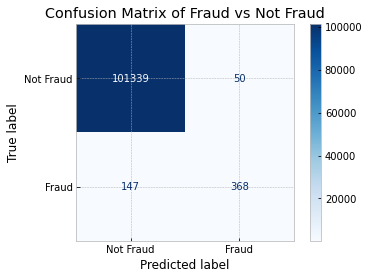

In [36]:
# Create confusion matrix of the RandomForestClassifier model performance
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, values_format='', display_labels=['Not Fraud', 'Fraud'], cmap='Blues')

# Set plot title
plt.title('Confusion Matrix of Fraud vs Not Fraud')

plt.show()

### __Insights on the Better Learning Method__

- The final confusion matrix shows the labels predicted by the model, which inclue 368 True Positives, 101,339 True Negatives, 50 False Positives and 147 False Negatives.
- The most important features in the learning of the model are <code>amt</code>, <code>hour</code>, <code>category_grocery_pos</code>, <code>age</code> and <code>avg_amt_30_day</code>. Out of the model's 10 most important features, half of them were features engineered from the original dataset features.
- Most of the important features relate to either amounts of money spent, or the category of purchase, although the hour of the day and age of the cardholder are also very important.
- <code>amt</code> is the most important feature in the learning of this algorithm, which makes sense given the disparity in the distribution of values between fraudulent and legitimate transaction, as was identified earlier through the boxplot visualizations.

## __Conclusion__

This study has explored the topic of fraudulent credit card transactions through the lens of data science, utilizing a dataset containing both legitimate and fraudulent transactions to firstly engineer new features, secondly conduct exploratory data analysis and thirdly to develop and evaluate machine learning models to detect fraud.

Feature engineering was employed to create several new features that describe meaningful aspects of the samples. These could then be used for visualization, and were important in the training of the machine learning models tested.

The final _GradientBoostingClassifier_ has a Recall score of 71.5%, which indicates it successfully detected 71.5% of the fraudulent observations in unseen data, the original purpose of this model.

The features which proved to be most important in the final model's classification prediction are those that involve the amounts associated with the transaction. Earlier EDA also reveals how there is a significant discrepancy between the distributions of the amount <code>amt</code> columns of the legitimate and fraudulent DataFrames, which is something the model likely considered to be significant.

The model does have room for improvement, however, especially to increase its ability to correctly predict more fraudulent transactions. Some strategies that could be experimented with involve: getting additional fraudulent transaction data that the model can learn from, fine tuning the model's hyper parameters through a grid search, or identifying and removing outliers from the amount column.

> Thanks

If you made it this far in looking through my project, thank you for your time :)